# 🏙️ Chicago Community Data Analysis

### 🎓 IBM Data Engineering Specialization – Portfolio Project
---

## 📘 Introduction
---
This project analyzes community-level data for the City of Chicago by combining socioeconomic indicators, public school performance data, and reported crime records. The datasets are stored in a SQLite relational database and queried using SQL to support data exploration and cross-table analysis, with additional visual insights created in the later stages of the project.

### ⚙️ Install Required Libraries
---
The following libraries are required to load data, manage the SQLite database, and execute SQL queries within the notebook.

In [1]:
!pip install pandas ipython-sql prettytable

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import sqlite3
import prettytable

prettytable.DEFAULT = 'DEFAULT'


### Create SQLite Database
---
To analyze the data using SQL, a SQLite database is created and a connection is established.

In [3]:
conn = sqlite3.connect('FinalDB.db')
cursor = conn.cursor()


### Load SQL Magic Module
---

The SQL magic module allows SQL queries to be executed directly within the notebook.

In [4]:
%load_ext sql


### Load CSV Files into DataFrames
---

The uploaded CSV files are loaded into pandas DataFrames.

In [5]:
census_df = pd.read_csv('Chicago_Census_Data.csv')
crime_df = pd.read_csv('Chicago_Crime_Data.csv')
schools_df = pd.read_csv('Chicago_Public_Schools.csv')


### Store Data in SQLite Tables
---

The DataFrames are written into SQLite tables for SQL-based analysis.

In [6]:
census_df.to_sql('CENSUS_DATA', conn, if_exists='replace', index=False)
crime_df.to_sql('CHICAGO_CRIME_DATA', conn, if_exists='replace', index=False)
schools_df.to_sql('CHICAGO_PUBLIC_SCHOOLS', conn, if_exists='replace', index=False)


566

### Connect SQL Magic to Database
---

This step establishes a connection between the SQL magic module and the SQLite database.

In [7]:
%sql sqlite:///FinalDB.db


# 🔍 Key Analytical Questions
---

The following SQL queries address key analytical questions derived from the Chicago community, crime, and education datasets.

**1. Find the total number of crimes recorded in the CRIME table.**




In [9]:
%%sql
SELECT COUNT(*) AS total_crimes
FROM CHICAGO_CRIME_DATA;


 * sqlite:///FinalDB.db
Done.


total_crimes
533


**2. List community area names and numbers with per capita income less than 11000.**

In [10]:
%%sql
SELECT Community_area_name, Community_area_number
FROM CENSUS_DATA
WHERE Per_capita_income < 11000;


 * sqlite:///FinalDB.db
Done.


Community_area_name,Community_area_number
West Garfield Park,26
South Lawndale,30
Fuller Park,37
Riverdale,54


**3. List all case numbers for crimes involving minors?(children are not considered minors for the purposes of crime analysis)**

In [11]:
%%sql
SELECT CASE_NUMBER
FROM CHICAGO_CRIME_DATA
WHERE DESCRIPTION LIKE '%MINOR%';


 * sqlite:///FinalDB.db
Done.


CASE_NUMBER
HL266884
HK238408


**4. List all kidnapping crimes involving a child?**

In [12]:
%%sql
SELECT CASE_NUMBER, PRIMARY_TYPE, DESCRIPTION
FROM CHICAGO_CRIME_DATA
WHERE PRIMARY_TYPE = 'KIDNAPPING'
  AND DESCRIPTION LIKE '%CHILD%';

 * sqlite:///FinalDB.db
Done.


CASE_NUMBER,PRIMARY_TYPE,DESCRIPTION
HN144152,KIDNAPPING,CHILD ABDUCTION/STRANGER


**5. List the kind of crimes that were recorded at schools. (No repetitions)**

In [13]:
%%sql
SELECT DISTINCT PRIMARY_TYPE
FROM CHICAGO_CRIME_DATA
WHERE LOCATION_DESCRIPTION LIKE '%SCHOOL%';


 * sqlite:///FinalDB.db
Done.


PRIMARY_TYPE
BATTERY
CRIMINAL DAMAGE
NARCOTICS
ASSAULT
CRIMINAL TRESPASS
PUBLIC PEACE VIOLATION


**6. List the type of schools along with the average safety score for each type.**

In [14]:
%%sql
SELECT
  "Elementary, Middle, or High School" AS school_type,
  AVG(SAFETY_SCORE) AS average_safety_score
FROM CHICAGO_PUBLIC_SCHOOLS
GROUP BY "Elementary, Middle, or High School";


 * sqlite:///FinalDB.db
Done.


school_type,average_safety_score
ES,49.52038369304557
HS,49.62352941176471
MS,48.0


**7. List 5 community areas with highest % of households below poverty line.**

In [15]:
%%sql
SELECT Community_area_name, Percent_households_below_poverty
FROM CENSUS_DATA
ORDER BY Percent_households_below_poverty DESC
LIMIT 5;

 * sqlite:///FinalDB.db
Done.


Community_area_name,Percent_households_below_poverty
Riverdale,56.5
Fuller Park,51.2
Englewood,46.6
North Lawndale,43.1
East Garfield Park,42.4


**8. Which community area is most crime prone? Display the coumminty area number only.**

In [16]:
%%sql
SELECT COMMUNITY_AREA_NUMBER
FROM CHICAGO_CRIME_DATA
GROUP BY COMMUNITY_AREA_NUMBER
ORDER BY COUNT(*) DESC
LIMIT 1;

 * sqlite:///FinalDB.db
Done.


COMMUNITY_AREA_NUMBER
25.0


**9. Use a sub-query to find the name of the community area with highest hardship index.**

In [17]:
%%sql
SELECT Community_area_name
FROM CENSUS_DATA
WHERE Hardship_index = (
  SELECT MAX(Hardship_index)
  FROM CENSUS_DATA
);

 * sqlite:///FinalDB.db
Done.


Community_area_name
Riverdale


**10. Use a sub-query to determine the Community Area Name with most number of crimes?**

In [18]:
%%sql
SELECT Community_area_name
FROM CENSUS_DATA
WHERE Community_area_number = (
  SELECT COMMUNITY_AREA_NUMBER
  FROM CHICAGO_CRIME_DATA
  GROUP BY COMMUNITY_AREA_NUMBER
  ORDER BY COUNT(*) DESC
  LIMIT 1
);

 * sqlite:///FinalDB.db
Done.


Community_area_name
Austin


## 🧠 Advanced SQL Techniques
---
This section demonstrates the use of advanced SQL concepts—including joins, views, and controlled data updates—to analyze relationships across community, education, and crime datasets.



### 1. Using Joins
---




**i. School Attendance in High-Hardship Communities.**

List school names, community names, and average attendance for communities with a hardship index of 98.

In [19]:
%%sql
SELECT
    s.NAME_OF_SCHOOL,
    c.Community_area_name,
    s.AVERAGE_STUDENT_ATTENDANCE
FROM CHICAGO_PUBLIC_SCHOOLS s
LEFT JOIN CENSUS_DATA c
ON s.COMMUNITY_AREA_NUMBER = c.Community_area_number
WHERE c.Hardship_index = 98;

 * sqlite:///FinalDB.db
Done.


NAME_OF_SCHOOL,Community_area_name,AVERAGE_STUDENT_ATTENDANCE
George Washington Carver Military Academy High School,Riverdale,91.60%
George Washington Carver Primary School,Riverdale,90.90%
Ira F Aldridge Elementary School,Riverdale,92.90%
William E B Dubois Elementary School,Riverdale,93.30%


**ii. Crimes That Took Place at Schools.**

List crimes occurring at school locations, including case number, crime type, and community name.

In [20]:
%%sql
SELECT
    cr.CASE_NUMBER,
    cr.PRIMARY_TYPE,
    c.Community_area_name
FROM CHICAGO_CRIME_DATA cr
LEFT JOIN CENSUS_DATA c
ON cr.COMMUNITY_AREA_NUMBER = c.Community_area_number
WHERE cr.LOCATION_DESCRIPTION LIKE '%SCHOOL%';


 * sqlite:///FinalDB.db
Done.


CASE_NUMBER,PRIMARY_TYPE,Community_area_name
HL353697,BATTERY,South Shore
HL725506,BATTERY,Lincoln Square
HP716225,BATTERY,Douglas
HH639427,BATTERY,Austin
JA460432,BATTERY,Ashburn
HS200939,CRIMINAL DAMAGE,Austin
HK577020,NARCOTICS,Rogers Park
HS305355,NARCOTICS,Brighton Park
HT315369,ASSAULT,East Garfield Park
HR585012,CRIMINAL TRESPASS,Ashburn


### 2: Creating a View
---

**i. Create a Privacy-Preserving School Ratings View.**

This view exposes school names and rating icons without revealing actual scores.

In [21]:
%%sql
CREATE VIEW IF NOT EXISTS SCHOOL_RATINGS_VIEW AS
SELECT
    NAME_OF_SCHOOL AS School_Name,
    Safety_Icon AS Safety_Rating,
    Family_Involvement_Icon AS Family_Rating,
    Environment_Icon AS Environment_Rating,
    Instruction_Icon AS Instruction_Rating,
    Leaders_Icon AS Leaders_Rating,
    Teachers_Icon AS Teachers_Rating
FROM CHICAGO_PUBLIC_SCHOOLS;


 * sqlite:///FinalDB.db
Done.


[]

**ii. View All Columns from the View.**

Displays all privacy-safe rating fields for each school from the created view.

In [22]:
%%sql
SELECT * FROM SCHOOL_RATINGS_VIEW;


 * sqlite:///FinalDB.db
Done.


School_Name,Safety_Rating,Family_Rating,Environment_Rating,Instruction_Rating,Leaders_Rating,Teachers_Rating
Abraham Lincoln Elementary School,Very Strong,Very Strong,Strong,Strong,Weak,Strong
Adam Clayton Powell Paideia Community Academy Elementary School,Average,Strong,Strong,Very Strong,Weak,Strong
Adlai E Stevenson Elementary School,Strong,NDA,Average,Weak,Weak,NDA
Agustin Lara Elementary Academy,Average,Average,Average,Weak,Weak,Average
Air Force Academy High School,Average,Strong,Strong,Average,Weak,Average
Albany Park Multicultural Academy,Strong,Weak,Strong,Strong,Weak,Average
Albert G Lane Technical High School,Very Strong,NDA,Strong,Average,Weak,NDA
Albert R Sabin Elementary Magnet School,Strong,NDA,Weak,Very Weak,Weak,NDA
Alcott High School for the Humanities,Strong,NDA,Strong,Average,Weak,NDA
Alessandro Volta Elementary School,Average,Strong,Weak,Weak,Weak,Average


**iii. View School Name and Leaders Rating Only.**

Retrieves only the school name and leadership rating for focused analysis.

In [23]:
%%sql
SELECT School_Name, Leaders_Rating
FROM SCHOOL_RATINGS_VIEW;


 * sqlite:///FinalDB.db
Done.


School_Name,Leaders_Rating
Abraham Lincoln Elementary School,Weak
Adam Clayton Powell Paideia Community Academy Elementary School,Weak
Adlai E Stevenson Elementary School,Weak
Agustin Lara Elementary Academy,Weak
Air Force Academy High School,Weak
Albany Park Multicultural Academy,Weak
Albert G Lane Technical High School,Weak
Albert R Sabin Elementary Magnet School,Weak
Alcott High School for the Humanities,Weak
Alessandro Volta Elementary School,Weak


## 📊 Visual Insights
---
This section presents visual insights derived from the integrated Chicago datasets to support exploratory analysis and pattern identification across communities, education, and crime.



In [31]:
import matplotlib.pyplot as plt

**1. Crime Distribution by Primary Type**

Shows which crime categories are most frequently reported across the city.

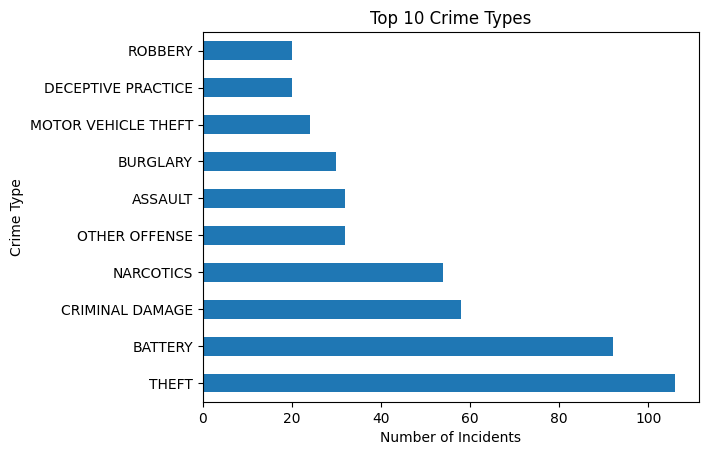

In [34]:
crime_type_counts = crime_df['PRIMARY_TYPE'].value_counts().head(10)
crime_type_counts.plot(kind='barh')
plt.xlabel('Number of Incidents')
plt.ylabel('Crime Type')
plt.title('Top 10 Crime Types')
plt.show()


**2. Crimes by Year**

Highlights yearly trends in reported crime incidents over time.

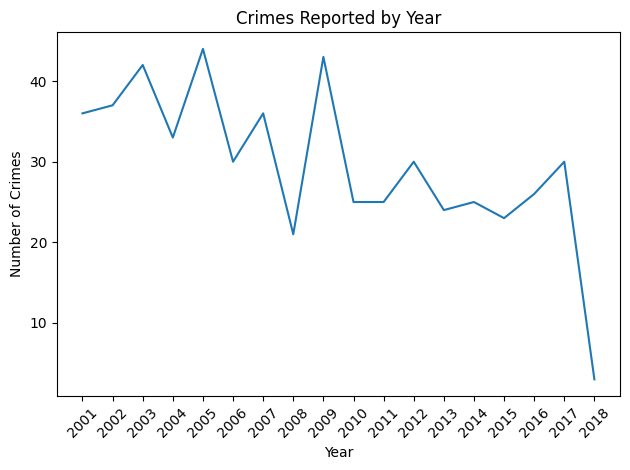

In [37]:
crime_year = crime_df['YEAR'].value_counts().sort_index()
plt.figure()
plt.plot(crime_year.index, crime_year.values)
plt.title('Crimes Reported by Year')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.xticks(crime_year.index, rotation=45)
plt.tight_layout()
plt.show()

**3. Poverty Rate by Community (Top 10)**

Identifies the communities with the highest percentage of households below the poverty line.

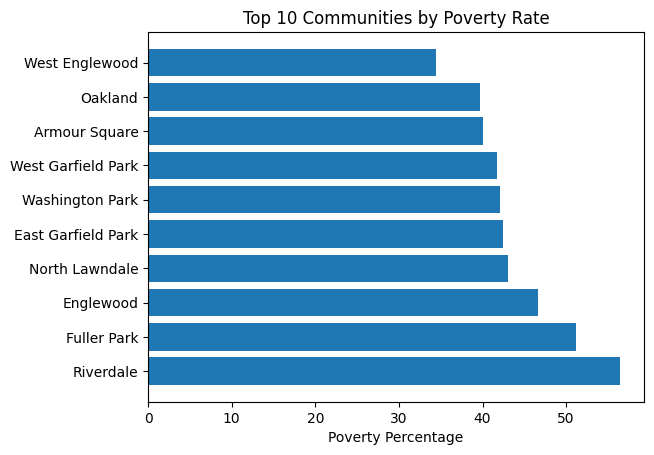

In [38]:
poverty = census_df.sort_values(
    'Percent_households_below_poverty', ascending=False
).head(10)
plt.barh(poverty['Community_area_name'], poverty['Percent_households_below_poverty'])
plt.title('Top 10 Communities by Poverty Rate')
plt.xlabel('Poverty Percentage')
plt.show()

**4. Hardship Index Distribution**

Displays how hardship levels are distributed across different community areas.

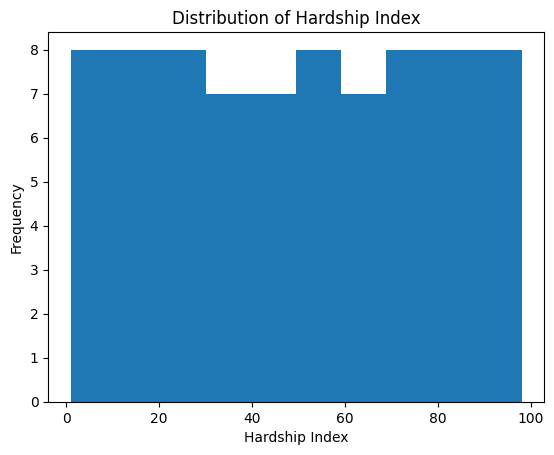

In [39]:
plt.hist(census_df['Hardship_index'], bins=10)
plt.title('Distribution of Hardship Index')
plt.xlabel('Hardship Index')
plt.ylabel('Frequency')
plt.show()

**5. Average Safety Score by School Type**

Compares average school safety scores across elementary, middle, and high schools.

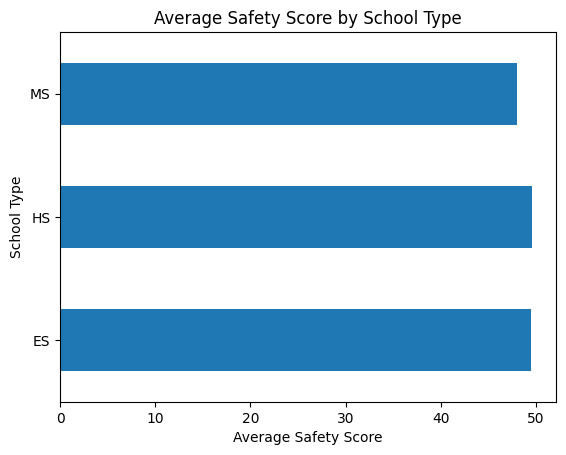

In [41]:
school_safety = schools_df.groupby('Elementary, Middle, or High School')['SAFETY_SCORE'].mean()

school_safety.plot(kind='barh')
plt.title('Average Safety Score by School Type')
plt.xlabel('Average Safety Score')
plt.ylabel('School Type')
plt.show()

**6. Relationship Between Poverty and Per Capita Income**

Illustrates the inverse relationship between poverty rates and income levels.

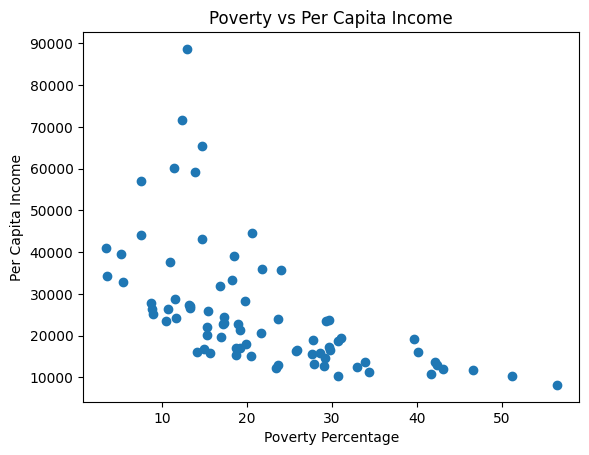

In [42]:
plt.scatter(
    census_df['Percent_households_below_poverty'],
    census_df['Per_capita_income']
)
plt.title('Poverty vs Per Capita Income')
plt.xlabel('Poverty Percentage')
plt.ylabel('Per Capita Income')
plt.show()

**7. Crimes Occurring at Schools vs Other Locations**

Compares the proportion of crimes occurring in school locations versus elsewhere.

In [44]:
import plotly.express as px

school_crimes = crime_df['LOCATION_DESCRIPTION'] \
    .str.contains('SCHOOL', na=False) \
    .value_counts() \
    .rename({True: 'School Locations', False: 'Non-School Locations'}) \
    .reset_index()

school_crimes.columns = ['Location Type', 'Incidents']

fig = px.pie(
    school_crimes,
    names='Location Type',
    values='Incidents',
    title='Crimes at School vs Non-School Locations',
    hole=0.4
)

fig.update_traces(
    textinfo='percent+label',
    pull=[0.05, 0]
)

fig.show()


**8. Average Student Attendance Distribution**

Shows how student attendance rates are distributed across public schools.

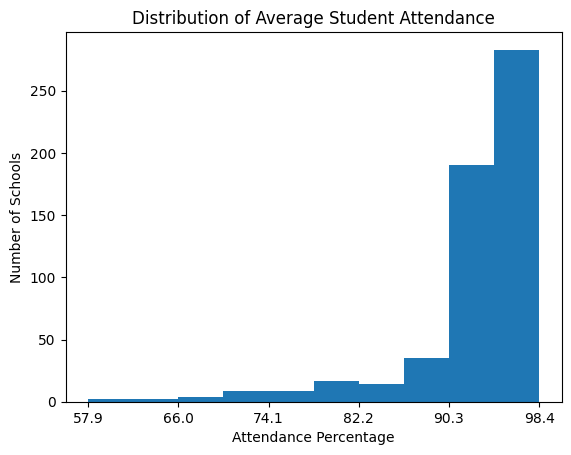

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Clean and convert attendance column to numeric
attendance = (
    schools_df['AVERAGE_STUDENT_ATTENDANCE']
    .astype(str)
    .str.replace('%', '', regex=False)
)

attendance = pd.to_numeric(attendance, errors='coerce')

# Drop missing values
attendance = attendance.dropna()

# Plot histogram with clean x-axis
plt.figure()
plt.hist(attendance, bins=10)
plt.title('Distribution of Average Student Attendance')
plt.xlabel('Attendance Percentage')
plt.ylabel('Number of Schools')

# Fix x-axis ticks
plt.xticks(np.linspace(attendance.min(), attendance.max(), 6))
plt.show()

## 📌 Key Findings

- A total of **533 crime incidents** were recorded in the analyzed dataset, with crime concentration varying significantly across community areas.
- **Riverdale** consistently emerged as a high-risk community, showing the **highest hardship index**, **highest poverty rate**, and multiple schools with comparatively lower attendance.
- **Community Area 25** was identified as the most crime-prone area based on incident frequency.
- Crimes occurring at **school locations** were primarily related to **battery, narcotics, and criminal damage**, indicating safety concerns around educational environments.
- Communities with **higher poverty levels** generally exhibited **lower per capita income**, reinforcing socioeconomic disparities.
- Average school **safety scores were similar across school types** (Elementary, Middle, High), suggesting systemic rather than isolated safety challenges.
- Leadership ratings across schools showed a high prevalence of **“Weak”** classifications, highlighting potential areas for administrative and policy improvement.
- The combined analysis demonstrates a strong relationship between **socioeconomic hardship, crime exposure, and educational conditions**, supporting the need for integrated, data-driven urban planning and policy interventions.
